# `CRO` fitting with CMIP6 models

This tutorial illustrates how to use the `pyCRO` to estimate RO parameters from all CMIP6 models

Contact:
 - Sen Zhao (zhaos@hawaii.edu)

## Load library

In [1]:
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

import os
import sys
    
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

## comment this if you install pyCRO already
sys.path.append(os.path.abspath("../../../"))

import pyCRO

## Fitting RO to the all CMIP6 models

### Load observed ENSO timeseries from CESM2

In [2]:
# load observations
file_name = os.path.join(os.getcwd(), "../../../data", "CROdata_timeseries_CMIP6.nc")
cmip_ds = xr.open_dataset(file_name)
cmip_ds

<xarray.Dataset> Size: 1MB
Dimensions:  (model: 48, time: 1332)
Coordinates:
  * time     (time) datetime64[ns] 11kB 1900-01-01 1900-02-01 ... 2010-12-01
  * model    (model) <U15 3kB 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    Nino3    (model, time) float32 256kB ...
    Nino34   (model, time) float32 256kB ...
    Hm       (model, time) float32 256kB ...
    Hw       (model, time) float32 256kB ...

In [3]:
def fit_dict_to_dataset(fit_dict):
    """
    Convert a single fit dictionary into an xarray.Dataset.
    Assigns dimensions based on the length of the parameter list:
        len=1 -> 'ac_0'
        len=3 -> 'ac_1'
        len=5 -> 'ac_2'
    Empty lists are replaced with np.nan (float).

    Parameters
    ----------
    fit_dict : dict
        Dictionary where keys are parameter names and values are lists.

    Returns
    -------
    xr.Dataset
    """
    data_vars = {}
    
    for k, v in fit_dict.items():
        if len(v) == 0:
            arr = np.array([np.nan], dtype=float)
            dim = "ac_0"
        elif len(v) == 1:
            arr = np.array(v, dtype=float)
            dim = "ac_0"
        elif len(v) == 3:
            arr = np.array(v, dtype=float)
            dim = "ac_1"
        elif len(v) == 5:
            arr = np.array(v, dtype=float)
            dim = "ac_2"
        else:
            # Other lengths: convert to float, pad with nan if needed
            arr = np.array(v, dtype=float)
            dim = f"ac_{len(v)}"
            
        data_vars[k] = (dim, arr)

    return xr.Dataset(data_vars)


def CRO_cmip6_fitting(par_option_T, par_option_h, par_option_noise, verbose=False):
    """
        fit all cmip6 models with the same T, h, and noise options
    """

    for i, model in enumerate(cmip_ds.model.values):
        par_tmp = pyCRO.RO_fitting(cmip_ds['Nino34'].sel(model=model), cmip_ds['Hm'].sel(model=model), 
                                   par_option_T, par_option_h, par_option_noise, verbose=verbose)        
        par_ds = fit_dict_to_dataset(par_tmp).assign_coords({'model': model})

        if i==0:
            par_cmip = par_ds
        else:
            par_cmip = xr.concat([par_cmip, par_ds], dim='model')
    return par_cmip


### Type Linear-White-Additive

Fit linear RO with white and additive noise 


In [4]:
par_option_T = {"R": 1, "F1": 1, "b_T": 0, "c_T": 0, "d_T": 0}
par_option_h = {"F2": 1, "epsilon": 1, "b_h": 0}
par_option_noise = {"T": "white", "h": "white", "T_type": "additive"}

par_cmip_LWA = CRO_cmip6_fitting(par_option_T, par_option_h, par_option_noise)
par_cmip_LWA

<xarray.Dataset> Size: 9kB
Dimensions:  (model: 48, ac_0: 1)
Coordinates:
  * model    (model) <U15 3kB 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Dimensions without coordinates: ac_0
Data variables: (12/16)
    R        (model, ac_0) float64 384B -0.0277 0.04347 ... 0.07818 0.006757
    F1       (model, ac_0) float64 384B 0.03008 0.0195 ... 0.03125 0.02193
    F2       (model, ac_0) float64 384B 1.138 1.671 1.259 ... 1.106 1.602 1.103
    epsilon  (model, ac_0) float64 384B 0.08306 0.1292 0.1211 ... 0.1831 0.09856
    b_T      (model, ac_0) float64 384B nan nan nan nan nan ... nan nan nan nan
    c_T      (model, ac_0) float64 384B nan nan nan nan nan ... nan nan nan nan
    ...       ...
    B        (model, ac_0) float64 384B nan nan nan nan nan ... nan nan nan nan
    m_T      (model, ac_0) float64 384B nan nan nan nan nan ... nan nan nan nan
    m_h      (model, ac_0) float64 384B nan nan nan nan nan ... nan nan nan nan
    n_T      (model, ac_0) float64 384B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    n_h      (model, ac_0) float64 384B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    n_g      (model, ac_0) float64 384B 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0

### Type Nonlinear-White-Additive

Fit nonlinear RO with red and additive noise 


In [5]:
par_option_T = {"R": 1, "F1": 1, "b_T": 1, "c_T": 1, "d_T": 1}
par_option_h = {"F2": 1, "epsilon": 1, "b_h": 1}
par_option_noise = {"T": "white", "h": "white", "T_type": "additive"}

par_cmip_NWA = CRO_cmip6_fitting(par_option_T, par_option_h, par_option_noise)
par_cmip_NWA

<xarray.Dataset> Size: 9kB
Dimensions:  (model: 48, ac_0: 1)
Coordinates:
  * model    (model) <U15 3kB 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Dimensions without coordinates: ac_0
Data variables: (12/16)
    R        (model, ac_0) float64 384B -0.02369 0.06183 ... 0.1074 0.0235
    F1       (model, ac_0) float64 384B 0.03023 0.01987 ... 0.0325 0.02317
    F2       (model, ac_0) float64 384B 1.129 1.654 1.259 ... 1.105 1.605 1.109
    epsilon  (model, ac_0) float64 384B 0.08266 0.1288 0.1332 ... 0.187 0.1002
    b_T      (model, ac_0) float64 384B 0.01088 -0.002446 ... 0.03614 0.03063
    c_T      (model, ac_0) float64 384B 0.0006461 0.00857 ... 0.005134 0.002772
    ...       ...
    B        (model, ac_0) float64 384B nan nan nan nan nan ... nan nan nan nan
    m_T      (model, ac_0) float64 384B nan nan nan nan nan ... nan nan nan nan
    m_h      (model, ac_0) float64 384B nan nan nan nan nan ... nan nan nan nan
    n_T      (model, ac_0) float64 384B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    n_h      (model, ac_0) float64 384B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    n_g      (model, ac_0) float64 384B 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0

## Understanding relationship between ENSO amplitude and RO parameters

calculation of seasonal variance

In [6]:
cmip_SD = cmip_ds['Nino34'].var('time')

Text(0.5, 0, '$\\sigma_T$ (K month$^{-1/2}$)')

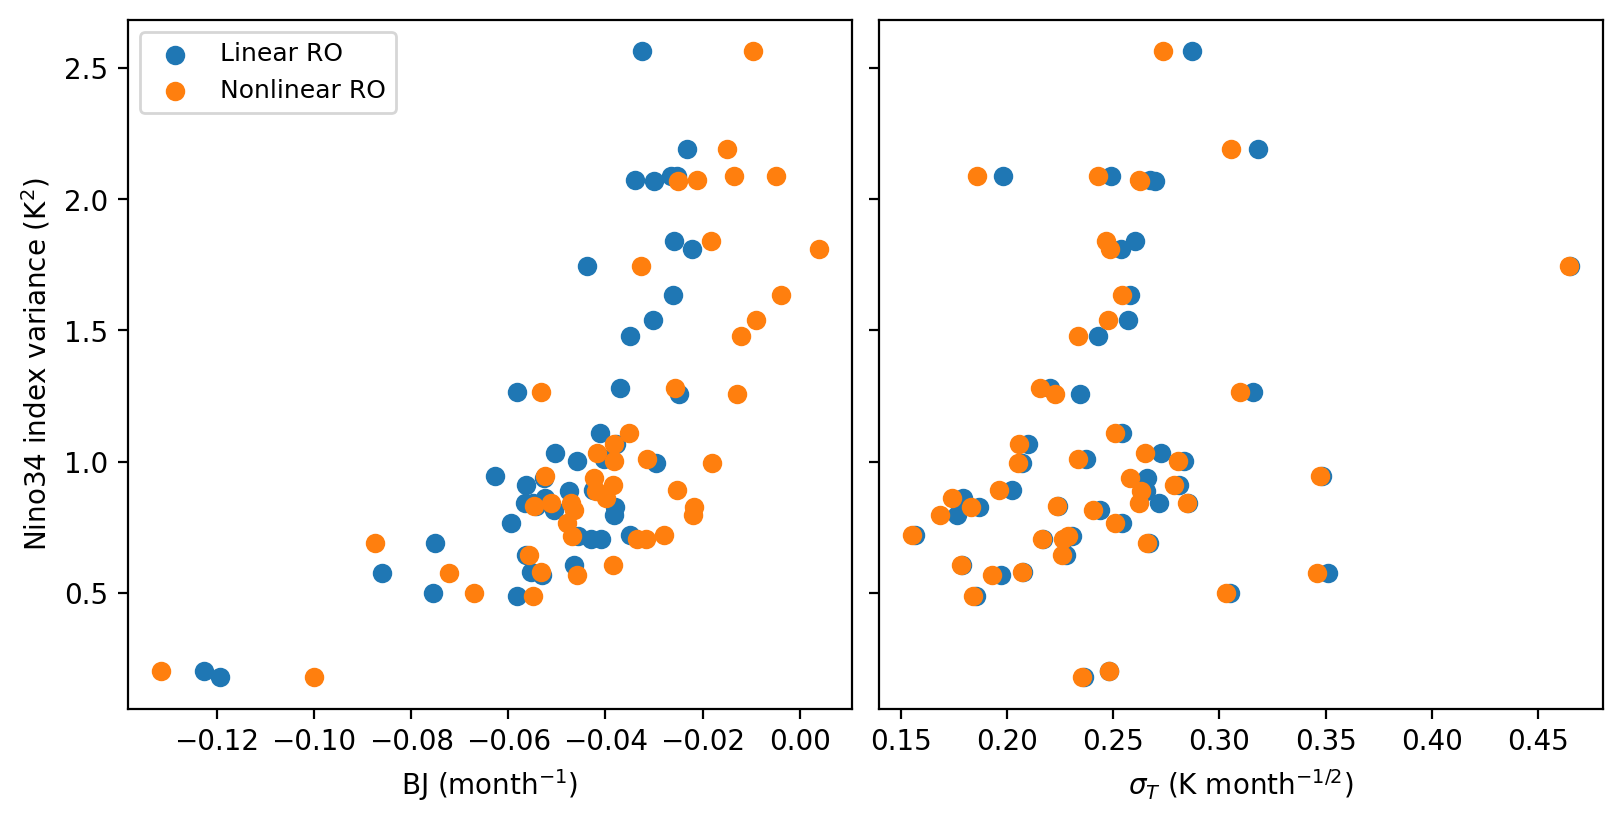

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, layout='compressed')

ax = axes[0]
ax.scatter((par_cmip_LWA['R']-par_cmip_LWA['epsilon'])*0.5, cmip_SD, label='Linear RO')
ax.scatter((par_cmip_NWA['R']-par_cmip_NWA['epsilon'])*0.5, cmip_SD, label='Nonlinear RO')
ax.set_xlabel('BJ (month$^{-1}$)')
ax.set_ylabel(r"Nino34 index variance (K$^2$)")
ax.legend(fontsize=9)

ax = axes[1]
ax.scatter(par_cmip_LWA['sigma_T'], cmip_SD, label='Linear RO')
ax.scatter(par_cmip_NWA['sigma_T'], cmip_SD, label='Nonlinear RO')
ax.set_xlabel(r"$\sigma_T$ (K month$^{-1/2}$)")
